# ETE 3

---

*~2347161*


## **Question 1 - LSTM Autoencoder**

Objective:
You are required to build an LSTM Autoencoder to detect anomalies in a time series dataset. The dataset contains daily temperature readings from a weather station over the course of a few years. Parameters in the dataset [Date and Temperature]



## 1. Load the dataset:

**The dataset will contain a single column temperature and a date column.**

In [5]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nndl/ete3/weather_data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2557 non-null   object 
 1   temperature  2557 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.1+ KB


> Converting the data colume to `datetime` field.

In [16]:
df['date'] = pd.to_datetime(df['date'])

print(df.info())
df.set_index('date', inplace=True)

print(df.head())
df.describe()


        date  temperature
0 2014-01-01    10.248357
1 2014-01-02     9.950428
2 2014-01-03    10.362958
3 2014-01-04    10.820167
4 2014-01-05     9.961091


,date,temperature
count,2557,2557.000000
mean,2017-07-02 00:00:00,10.017472
min,2014-01-01 00:00:00,3.337291
25%,2015-10-02 00:00:00,9.335195
50%,2017-07-02 00:00:00,10.031778
75%,2019-04-02 00:00:00,10.681384
max,2020-12-31 00:00:00,15.587945
std,NaN,0.923047


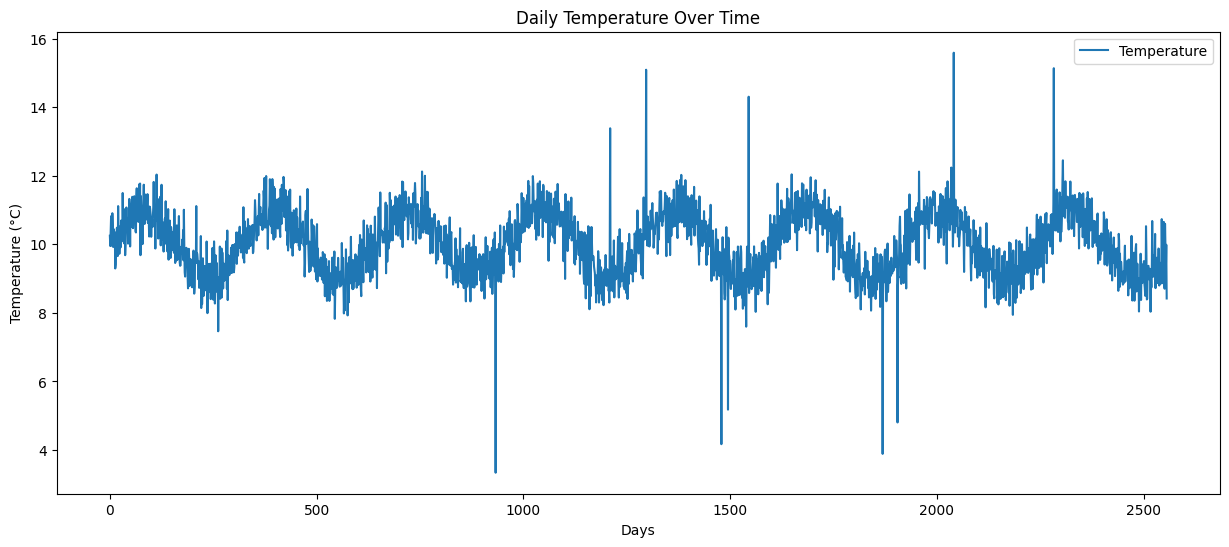

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['temperature'], label='Temperature')
plt.title('Daily Temperature Over Time')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


## 2. Preprocess the data:

**Normalize the temperature data and split it into training and testing sets.**

In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the temperature data
scaler = MinMaxScaler(feature_range=(0, 1))
df['normalized_temp'] = scaler.fit_transform(df[['temperature']])

# Define a function to create sequences for LSTM input
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

# Set sequence length
SEQ_LENGTH = 30

# Create sequences
sequences = create_sequences(df['normalized_temp'].values, SEQ_LENGTH)

# Split data into training (80%) and testing (20%)
train_size = int(0.8 * len(sequences))
train_data, test_data = sequences[:train_size], sequences[train_size:]



[[0.56413854 0.53981913 0.57349321 ... 0.60033617 0.56185907 0.57582337]
 [0.53981913 0.57349321 0.61081438 ... 0.56185907 0.57582337 0.56450865]
 [0.57349321 0.61081438 0.54068948 ... 0.57582337 0.56450865 0.66598684]
 ...
 [0.64970479 0.57284985 0.62550314 ... 0.65022834 0.60340174 0.60190979]
 [0.57284985 0.62550314 0.63397557 ... 0.60340174 0.60190979 0.58778036]
 [0.62550314 0.63397557 0.67775626 ... 0.60190979 0.58778036 0.60634888]]


## 3. Build an LSTM Autoencoder:

- The encoder should reduce the input dimensions to a latent representation.
- The decoder should reconstruct the input from the latent representation.

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Define the Autoencoder architecture
def build_autoencoder(seq_length, num_features):
    # Encoder
    inputs = Input(shape=(seq_length, num_features))
    encoded = LSTM(64, activation='relu')(inputs)
    encoded = Dense(32, activation='relu')(encoded)

    # Decoder
    decoded = RepeatVector(seq_length)(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(num_features))(decoded)

    # Autoencoder model
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Build the autoencoder
autoencoder = build_autoencoder(SEQ_LENGTH, 1)

# Summary of the model
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 32)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            24832     
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             65        
 ributed)                                                    

## 4. Train the model:

**Train the autoencoder on the training data and evaluate the reconstruction error on the test set.**

In [32]:
# Reshape the data to fit the LSTM input format (samples, timesteps, features)
train_data = train_data.reshape(train_data.shape[0], SEQ_LENGTH, 1)
test_data = test_data.reshape(test_data.shape[0], SEQ_LENGTH, 1)

# Train the model
history = autoencoder.fit(
    train_data, train_data,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/50
57/57 [==============================] - 4s 30ms/step - loss: 0.0774 - val_loss: 0.0173
Epoch 2/50
57/57 [==============================] - 1s 22ms/step - loss: 0.0127 - val_loss: 0.0111
Epoch 3/50
57/57 [==============================] - 1s 21ms/step - loss: 0.0080 - val_loss: 0.0097
Epoch 4/50
57/57 [==============================] - 1s 22ms/step - loss: 0.0055 - val_loss: 0.0271
Epoch 5/50
57/57 [==============================] - 1s 20ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 6/50
57/57 [==============================] - 1s 20ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 7/50
57/57 [==============================] - 1s 20ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 8/50
57/57 [==============================] - 1s 21ms/step - loss: 0.0031 - val_loss: 0.0088
Epoch 9/50
57/57 [==============================] - 1s 22ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 10/50
57/57 [==============================] - 1s 21ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 11/

## 5. Anomaly Detection: Use the reconstruction error to detect anomalies.

**Define a threshold for the reconstruction error, and identify days where the temperature is considered anomalous.**

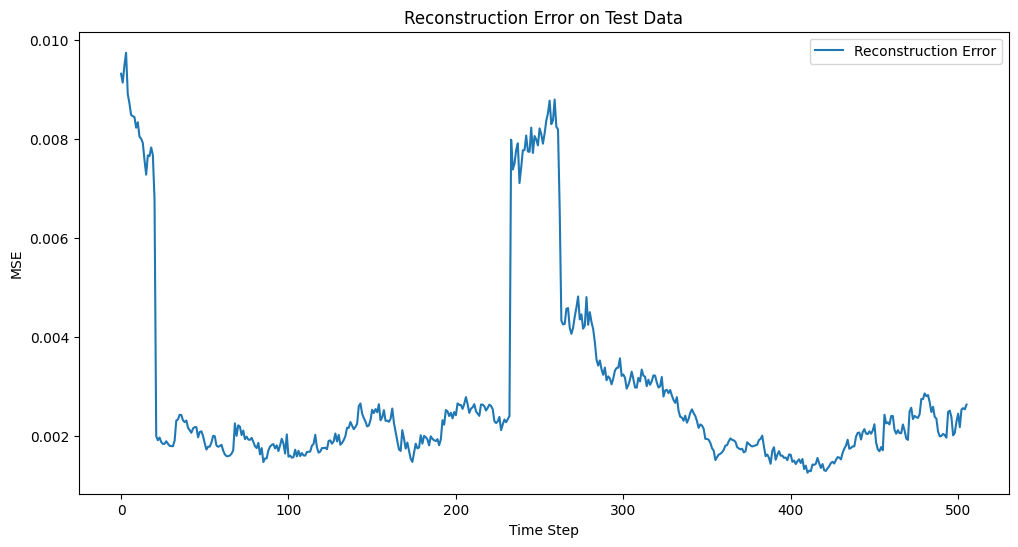

In [73]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Predict the reconstruction on test data
predictions = autoencoder.predict(test_data)

# Compute the Mean Squared Error for each sequence
reconstruction_errors = np.mean(np.power(test_data - predictions, 2), axis=(1, 2))

# Plot the reconstruction errors
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.title('Reconstruction Error on Test Data')
plt.xlabel('Time Step')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 99)  # Example: 95th percentile
print(threshold)
# Identify anomalies
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")


In [74]:
# Set threshold using the 95th percentile of the reconstruction errors
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies
anomalies = reconstruction_errors > threshold

# Get the corresponding dates of anomalies
anomalous_dates = df.index[len(train_data) + SEQ_LENGTH:][anomalies]
anomalous_temperatures = df['temperature'].iloc[len(train_data) + SEQ_LENGTH:][anomalies]

# Display the anomalies
anomalies_df = pd.DataFrame({
    'Date': anomalous_dates,
    'Temperature': anomalous_temperatures,
    'Reconstruction Error': reconstruction_errors[anomalies]
})




      Date  Temperature  Reconstruction Error
2051  2051    10.225384              0.009322
2052  2052    10.315052              0.009142
2053  2053    10.477161              0.009489
2054  2054     9.940762              0.009746
2055  2055    10.188508              0.008912
2056  2056    10.344236              0.008727
2057  2057    11.003528              0.008490
2058  2058    10.681384              0.008464
2059  2059    10.630459              0.008448
2060  2060    10.942468              0.008232
2061  2061    10.431491              0.008343
2062  2062    10.678376              0.008053
2293  2293    10.362092              0.008074
2296  2296    11.011793              0.008234
2298  2298    11.150537              0.008064
2301  2301    10.357980              0.008219
2302  2302    10.674940              0.008102
2304  2304    11.883592              0.008117
2305  2305    12.449627              0.008372
2306  2306    11.206597              0.008526
2307  2307    10.819858           

## 6. Visualize the results:


**Plot the original temperature data and highlight the detected anomalies.**

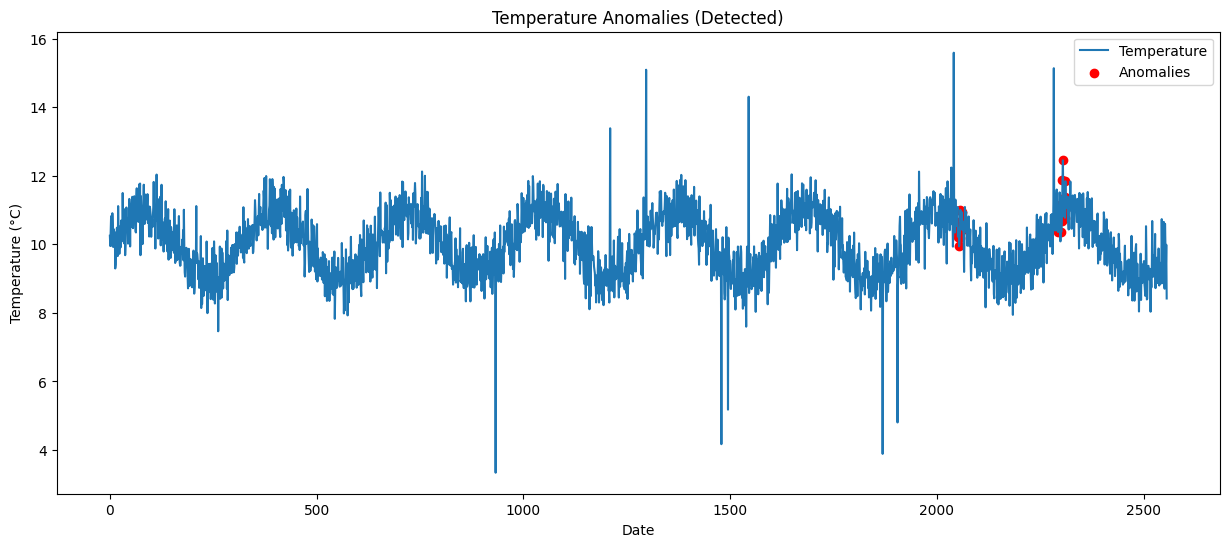

      Date  Temperature  Reconstruction Error
2051  2051    10.225384              0.009322
2052  2052    10.315052              0.009142
2053  2053    10.477161              0.009489
2054  2054     9.940762              0.009746
2055  2055    10.188508              0.008912
2056  2056    10.344236              0.008727
2057  2057    11.003528              0.008490
2058  2058    10.681384              0.008464
2059  2059    10.630459              0.008448
2060  2060    10.942468              0.008232
2061  2061    10.431491              0.008343
2062  2062    10.678376              0.008053
2293  2293    10.362092              0.008074
2296  2296    11.011793              0.008234
2298  2298    11.150537              0.008064
2301  2301    10.357980              0.008219
2302  2302    10.674940              0.008102
2304  2304    11.883592              0.008117
2305  2305    12.449627              0.008372
2306  2306    11.206597              0.008526
2307  2307    10.819858           

In [76]:
import numpy as np

# Compute reconstruction errors
reconstruction_errors = np.mean(np.power(test_data - predictions, 2), axis=(1, 2))


# Compute IQR
Q1 = np.percentile(reconstruction_errors, 45)
Q3 = np.percentile(reconstruction_errors, 90)
IQR = Q3 - Q1

# Define threshold
threshold = Q3 + 1.5 * IQR  # Detect points outside upper bound

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['temperature'], label='Temperature')
plt.scatter(anomalous_dates, anomalous_temperatures, color='red', label='Anomalies')
plt.title('Temperature Anomalies (Detected)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


print(anomalies_df)